In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import sys
import time
import multiprocessing
from tqdm import tqdm

from PyToF import ClassToF

In [2]:
def Movshovitz(args):

    N, order, alphas = args

    sys.path.append('nmovshov_ToFPlanet/')
    import TOFPlanet 

    res = TOFPlanet.TOFPlanet(  N          = N,
                                nx         = -1,
                                toforder   = order,
                                dJtol      = 1e-10,
                                drottol    = 1e-10,
                                drhotol    = 1e-10,
                                MaxIterHE  = 2,
                                MaxIterBar = 100,
                                verbosity  = 0,
                                )

    res.G           = 6.6738480e-11                                         #m^3kg^-1s^-2
    res.GM          = 126686536.1*(1000)**3                                 #m^3s^-2
    res.mass        = res.GM/res.G                                          #kg
    res.radius      = 71492000                                              #m         
    res.period      = 2*np.pi/np.sqrt((res.GM*0.089195487)/(res.radius**3)) #s
    res.P0          = 0

    res.si          = res.radius*np.linspace(1, 1/N, N) 
    res.rhoi        = np.ones(N)*res.mass/(4*np.pi/3*res.radius**3)

    def barotrope(P): return np.sqrt(P)
    res.set_barotrope(barotrope)

    tic = time.time()
    it = res.relax_to_barotrope()
    toc = time.time()

    return toc-tic, np.hstack([res.aos, res.Js[1:]]), it

In [3]:
def Morf(args):

    N, nx, order, alphas = args

    res = ClassToF.ToF(N = N, nx = nx, order = order, alphas = alphas, verbosity=0, R_ref=71492000)
    
    def barotrope(P, param): return np.sqrt(P)
    res.set_barotrope(barotrope)

    tic = time.time()
    it = res.relax_to_barotrope(fixradius=True, fixmass=True, fixrot=True, pressurize=True)
    toc = time.time()

    return toc-tic, np.hstack([res.R_eq_to_R_m, res.Js[1:]]), it

In [4]:
def get_res(Ns, steps, alphas):

    res_04_Morf = np.zeros((len(Ns), 5, len(steps)))
    res_07_Morf = np.zeros((len(Ns), 8, len(steps)))
    res_10_Morf = np.zeros((len(Ns), 11,len(steps)))

    res_04_Movs = np.zeros((len(Ns), 5))
    res_07_Movs = np.zeros((len(Ns), 8))

    time_04_Morf = np.zeros((len(Ns), len(steps)))
    time_07_Morf = np.zeros((len(Ns), len(steps)))
    time_10_Morf = np.zeros((len(Ns), len(steps)))

    time_04_Movs = np.zeros(len(Ns))
    time_07_Movs = np.zeros(len(Ns))

    tasks_04_Morf = [(int(Ns[i]), int(Ns[i]/steps[j]), 4,  alphas) for i in range(len(Ns)) for j in range(len(steps))]
    tasks_07_Morf = [(int(Ns[i]), int(Ns[i]/steps[j]), 7,  alphas) for i in range(len(Ns)) for j in range(len(steps))]
    tasks_10_Morf = [(int(Ns[i]), int(Ns[i]/steps[j]), 10, alphas) for i in range(len(Ns)) for j in range(len(steps))]

    coord_Morf = [(i,j) for i in range(len(Ns)) for j in range(len(steps))]

    tasks_04_Movs = [(int(Ns[i]), 4, alphas) for i in range(len(Ns))]
    tasks_07_Movs = [(int(Ns[i]), 7, alphas) for i in range(len(Ns))]

    """
    for i in range(len(Ns)):

        print('Movs')
        time_04_Movs[i], res_04_Movs[i,:], it = Movshovitz([int(Ns[i]), 4, alphas])
        time_07_Movs[i], res_07_Movs[i,:], it = Movshovitz([int(Ns[i]), 7, alphas])
        
        time_04_Movs[i] /= it
        time_07_Movs[i] /= it

        for j in range(len(steps)):

            print('Morf')
            time_04_Morf[i,j], res_04_Morf[i,:,j], it = Morf([int(Ns[i]), int(Ns[i]/steps[j]), 4,  alphas])
            time_07_Morf[i,j], res_07_Morf[i,:,j], it = Morf([int(Ns[i]), int(Ns[i]/steps[j]), 7,  alphas])
            time_10_Morf[i,j], res_10_Morf[i,:,j], it = Morf([int(Ns[i]), int(Ns[i]/steps[j]), 10, alphas])

            time_04_Morf[i,j] /= it
            time_07_Morf[i,j] /= it
            time_10_Morf[i,j] /= it

            print()
            print('N =', int(Ns[i]), 'and nx =', int(Ns[i]/steps[j]))
            print('time_04_Morf:', "{:.2f}".format(time_04_Morf[i,j]), 's', 'time_07_Morf:', "{:.2f}".format(time_07_Morf[i,j]), 's', 'time_10_Morf:', "{:.2f}".format(time_10_Morf[i,j]), 's')
            print('time_04_Movs:', "{:.2f}".format(time_04_Movs[i]),   's', 'time_07_Movs:', "{:.2f}".format(time_07_Movs[i]),   's')
    """

    with multiprocessing.Pool() as pool:

        print('4th order Theory of Figures, Morf:')
        all_04_Morf = list(tqdm(pool.imap(Morf, tasks_04_Morf), total=len(tasks_04_Morf)))
        
        print('7th order Theory of Figures, Morf:')
        all_07_Morf = list(tqdm(pool.imap(Morf, tasks_07_Morf), total=len(tasks_07_Morf)))

        print('10th order Theory of Figures, Morf:')
        all_10_Morf = list(tqdm(pool.imap(Morf, tasks_10_Morf), total=len(tasks_10_Morf)))

        print('4th order Theory of Figures, Movshovitz:')
        all_04_Movs = list(tqdm(pool.imap(Movshovitz, tasks_04_Movs), total=len(tasks_04_Movs)))
        
        print('7th order Theory of Figures, Movshovitz:')
        all_07_Movs = list(tqdm(pool.imap(Movshovitz, tasks_07_Movs), total=len(tasks_07_Movs)))
    
    for i in range(len(all_04_Morf)):

        time_04_Morf[coord_Morf[i][0],  coord_Morf[i][1]] = all_04_Morf[i][0]/all_04_Morf[i][2]
        res_04_Morf[ coord_Morf[i][0],:,coord_Morf[i][1]] = all_04_Morf[i][1]   

        time_07_Morf[coord_Morf[i][0],  coord_Morf[i][1]] = all_07_Morf[i][0]/all_07_Morf[i][2]
        res_07_Morf[ coord_Morf[i][0],:,coord_Morf[i][1]] = all_07_Morf[i][1] 

        time_10_Morf[coord_Morf[i][0],  coord_Morf[i][1]] = all_10_Morf[i][0]/all_10_Morf[i][2]
        res_10_Morf[ coord_Morf[i][0],:,coord_Morf[i][1]] = all_10_Morf[i][1]  

    for i in range(len(all_04_Movs)):

        time_04_Movs[i]  = all_04_Movs[i][0]/all_04_Movs[i][2]
        res_04_Movs[i,:] = all_04_Movs[i][1]

        time_07_Movs[i]  = all_07_Movs[i][0]/all_07_Movs[i][2]
        res_07_Movs[i,:] = all_07_Movs[i][1]

    return res_04_Morf, res_07_Morf, res_10_Morf, res_04_Movs, res_07_Movs, time_04_Morf, time_07_Morf, time_10_Morf, time_04_Movs, time_07_Movs

In [5]:
def plot_res(Ns, steps, alphas, res_analytical, what):

    res_04_Morf, res_07_Morf, res_10_Morf, res_04_Movs, res_07_Movs, time_04_Morf, time_07_Morf, time_10_Morf, time_04_Movs, time_07_Movs = get_res(Ns, steps, alphas)

    titles = [  r'Mean radius / equatorial radius', r'$J_{2}$', r'$J_{4}$', r'$J_{6}$', r'$J_{8}$', r'$J_{10}$', r'$J_{12}$', r'$J_{14}$', r'$J_{16}$', r'$J_{18}$', r'$J_{20}$', None]
    names  = [  'R_eq_to_R_m', 'J_2', 'J_4', 'J_6', 'J_8', 'J_10', 'J_12', 'J_14', 'J_16', 'J_18', 'J_20', 'time']

    styles = ['solid', 'dashed']

    # Plot data on each subplot
    for i in range(12):

        fig = plt.figure(layout='constrained')
        ax  = fig.gca()

        for j in range(len(steps)):

            step = steps[j]

            if i<5:

                ax.plot(Ns, np.abs((res_04_Morf[:,i,j] - res_analytical[i]) / res_analytical[i]), "o", linestyle = styles[j], color = 'C0', ms = 8)

                if  j==0:

                    if np.max(alphas) == 0:
                        ax.plot(Ns, np.abs((res_04_Movs[:,i] - res_analytical[i]) / res_analytical[i]), "X", linestyle = styles[j], color = 'C0', ms = 9)

            if i<8:

                ax.plot(Ns, np.abs((res_07_Morf[:,i,j] - res_analytical[i]) / res_analytical[i]), "o", linestyle = styles[j], color = 'C1', ms = 6)

                if  j==0:

                    if np.max(alphas) == 0:
                        ax.plot(Ns, np.abs((res_07_Movs[:,i] - res_analytical[i]) / res_analytical[i]), "X", linestyle = styles[j], color = 'C1', ms = 7)

            if i<11:

                ax.plot(Ns, np.abs((res_10_Morf[:,i,j] - res_analytical[i]) / res_analytical[i]), "o", linestyle = styles[j], color = 'C2', ms = 4)

            if i==11:
                
                ax.plot(Ns, time_04_Morf[:,j], "o", linestyle = styles[j], color = 'C0', ms = 8)
                ax.plot(Ns, time_07_Morf[:,j], "o", linestyle = styles[j], color = 'C1', ms = 6)
                ax.plot(Ns, time_10_Morf[:,j], "o", linestyle = styles[j], color = 'C2', ms = 4)

                if j==0:

                    if np.max(alphas) == 0:
                        ax.plot(Ns, time_04_Movs, "X", linestyle = styles[j], color = 'C0', ms = 9)
                        ax.plot(Ns, time_07_Movs, "X", linestyle = styles[j], color = 'C1', ms = 7)

        p1, = ax.plot(np.nan, np.nan, linestyle='solid',  color = 'C0')
        p2, = ax.plot(np.nan, np.nan, linestyle='solid',  color = 'C1')
        p3, = ax.plot(np.nan, np.nan, linestyle='solid',  color = 'C2')
        p4, = ax.plot(np.nan, np.nan, linestyle='solid',  color = 'black')
        p5, = ax.plot(np.nan, np.nan, linestyle='dashed', color = 'black')
        if np.max(alphas) == 0:
            p6, = ax.plot(np.nan, np.nan, "o", color = 'black')
            p7, = ax.plot(np.nan, np.nan, "X", color = 'black')

        ax.set_xscale('log', base=2)

        if i!=0 or what=='Bessel': 

            ax.set_yscale('log')

        ax.set_title(titles[i], fontsize=20)
        ax.set_xlabel(r'$N$', fontsize=20)

        if i !=11:

            ax.set_ylabel('Rel. diff. to ref solution'.replace("ref", what), fontsize=20)

        else:

            ax.set_ylabel('runtime [s] per iteration', fontsize=20)

        ax.set_xmargin(0.05)
        ax.set_ymargin(0.05)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        if np.max(alphas) == 0:
            ax.legend([(p1,p2,p3),p4,p5,p6,p7], ['ToF 4, 7, 10', r'$n_x = N$' , r'$n_x = \frac{N}{32}$' , 'Morf+ 24', 'M&F 22'], handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, fontsize=12)
        else:
            ax.legend([(p1,p2,p3),p4,p5], ['ToF 4, 7, 10', r'$n_x = N$' , r'$n_x = \frac{N}{32}$'], handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=2, fontsize=12)

        fig.savefig('PyToF_Accuracy_and_Convergence_Images/' + names[i] +  '_' + what + '.png', dpi=200, format='png', bbox_inches='tight')

In [6]:
#Numbers are taken from Wisdom & Hubbard 2016, Differential rotation in Jupiter: A comparison of methods: 
Bessel  = np.array([1.022875431133174e0, 1.398851089834702e-2, -5.318281001092907e-4, 3.011832290533641e-5, -2.132115710725050e-6, 1.740671195871128e-7, -1.568219505602588e-8,  1.518099230068580e-9, -1.551985393081485e-10, 1.655948019619652e-11, -1.829544870258362e-12])
CMSDR2  = np.array([np.nan,              1.399685529663848e-2, -5.358080750264726e-4, 3.159100841281628e-5, -2.626580737287536e-6, 2.745394255627955e-7, -3.247718410175606e-8,  4.106439257702602e-9, -5.430942499498113e-10, 7.456525895586537e-11, -1.057232912152619e-11])
CMSDR3  = np.array([np.nan,              1.399739489765669e-2, -5.358967290243679e-4, 3.163072519976169e-5, -2.715682955893595e-6, 3.482051102658201e-7,  1.908012504014946e-8, -1.019589599416940e-7,  1.028205395308815e-7, -2.636937795839493e-8,  -3.593890869111017e-8  ])

Ns      = 2**np.linspace(7,15,9)
steps   = [1, 32]

4th order Theory of Figures, Morf:


/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide0/18 [00:00<?, ?it/s]
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.p

7th order Theory of Figures, Morf:


/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide0/18 [00:00<?, ?it/s]
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
100%|████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.00s/it]


10th order Theory of Figures, Morf:


100%|████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:53<00:00,  2.96s/it]


4th order Theory of Figures, Movshovitz:


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.87it/s]


7th order Theory of Figures, Movshovitz:


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:40<00:00, 17.83s/it]


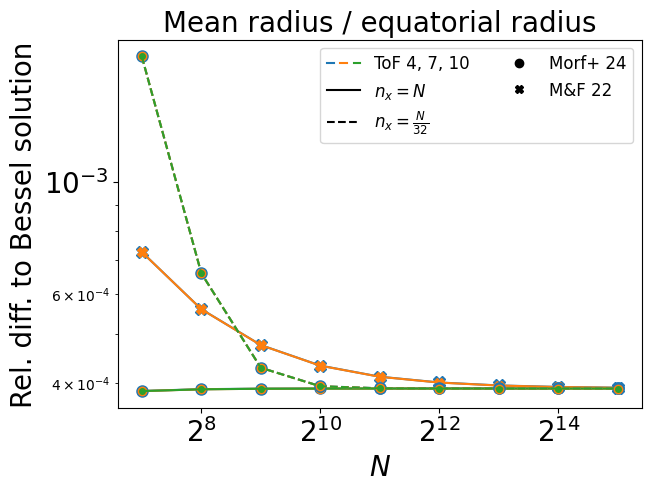

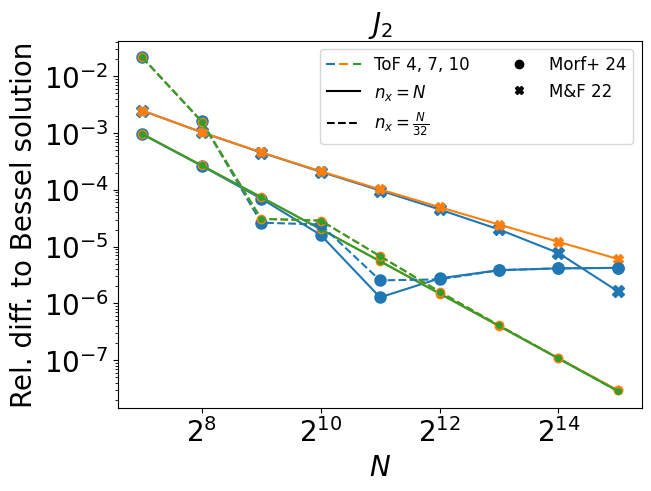

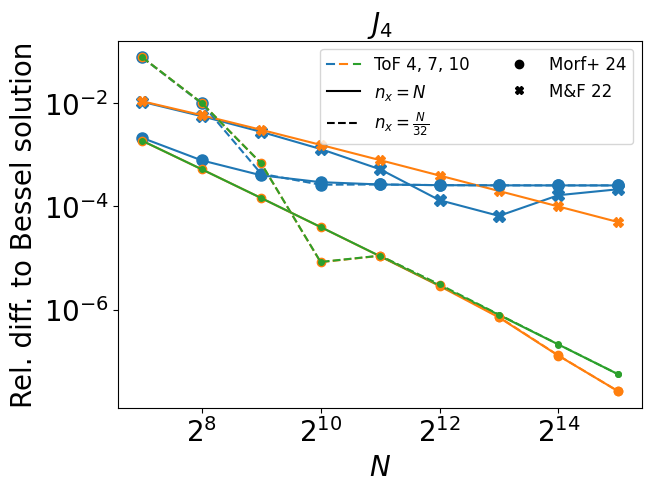

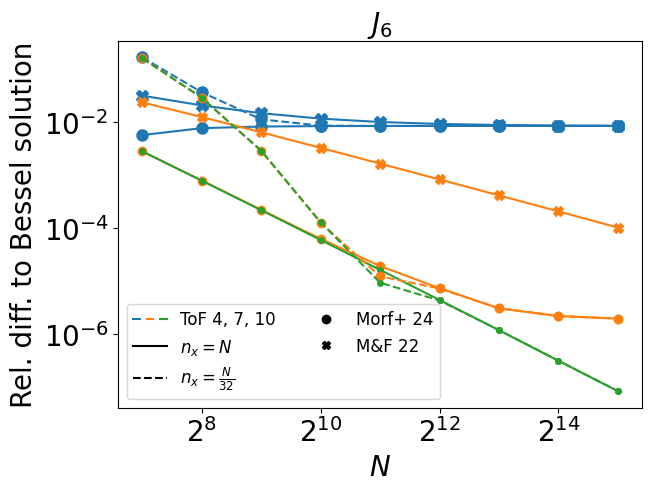

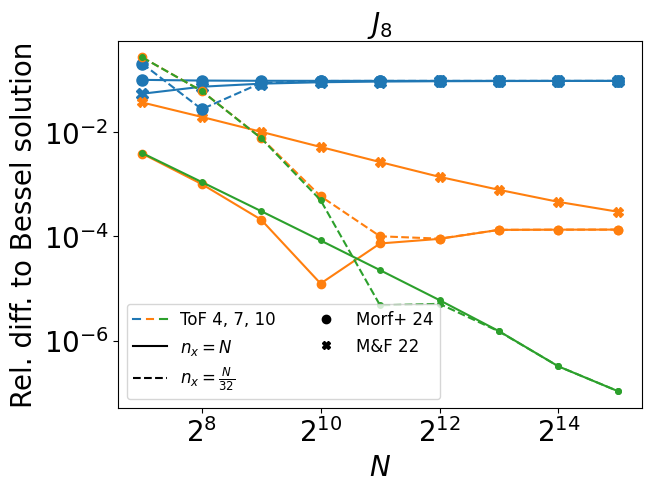

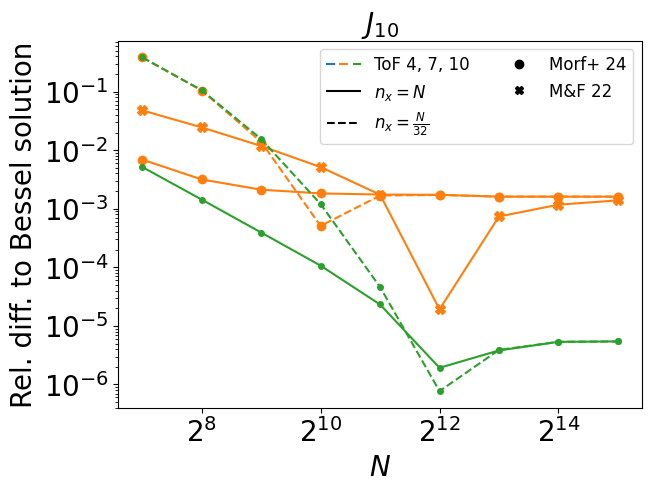

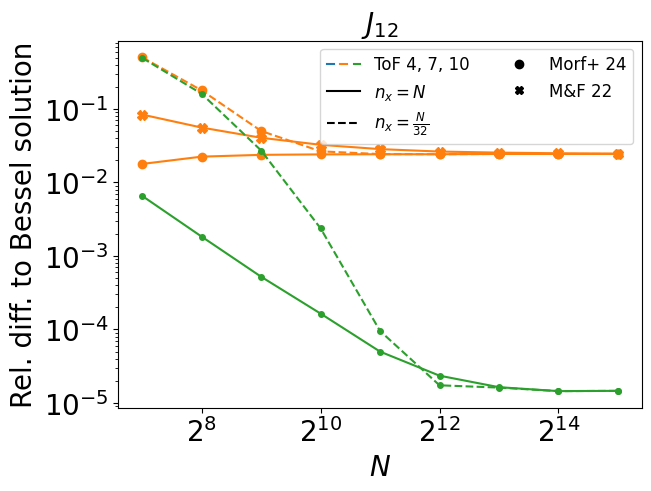

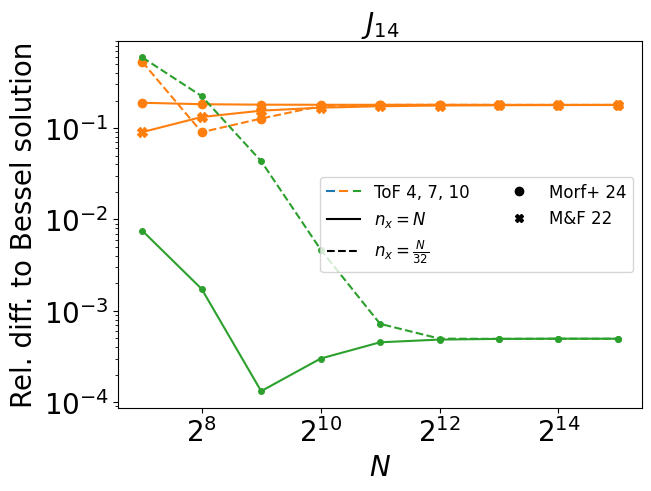

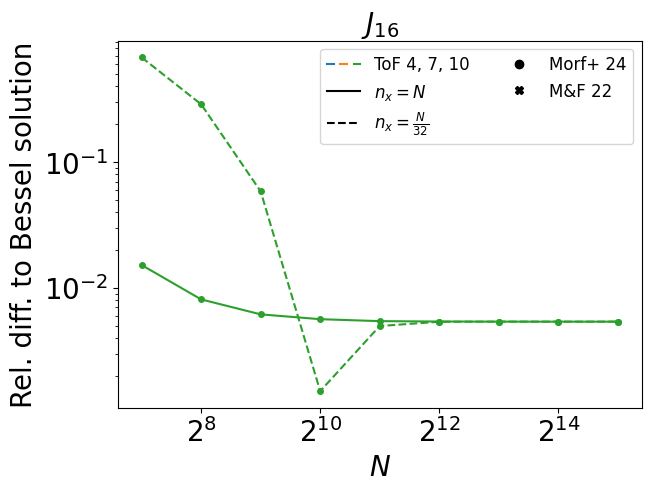

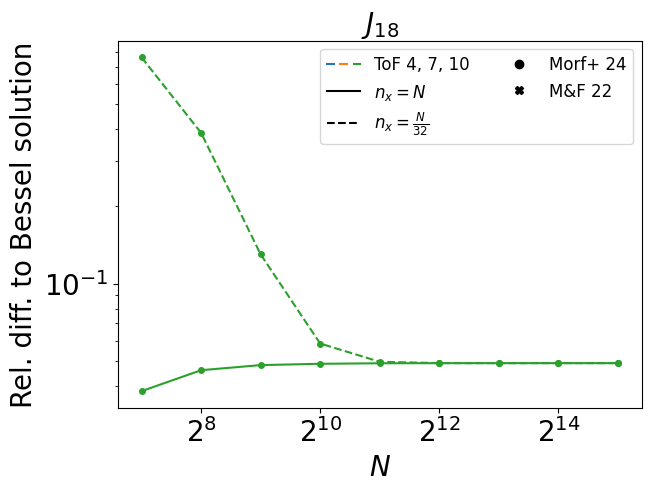

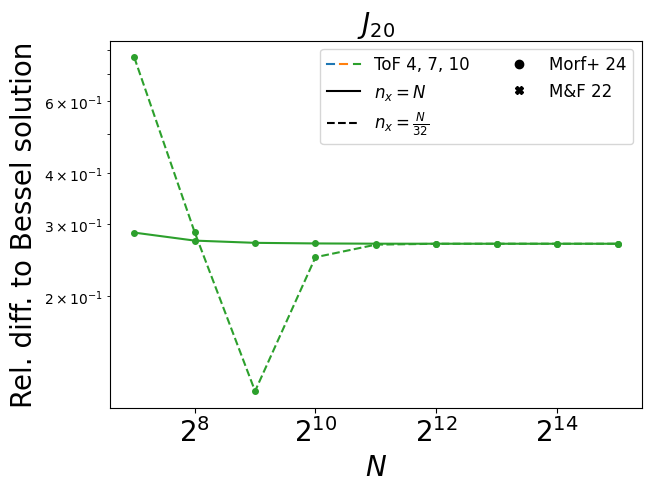

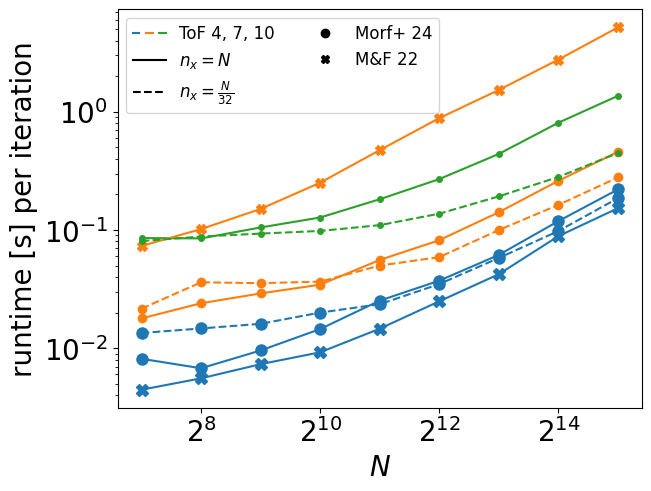

In [7]:
alphas = np.zeros(12)
plot_res(Ns, steps, alphas, Bessel, 'Bessel')

In [ ]:
A2 = -5.8954166431924311100e-2 * 1e6 # m^2 s^-2
A4 =  4.6123389620922838894e-1 * 1e6 # m^2 s^-2
A6 = -1.0426642770099761037e0  * 1e6 # m^2 s^-2
A8 =  8.3030636453130002295e-1 * 1e6 # m^2 s^-2

alphas = np.array([A2, A4, A6, A8, 0, 0, 0, 0, 0, 0, 0, 0])
plot_res(Ns, steps, alphas, CMSDR2, 'CMS_DR2')

4th order Theory of Figures, Morf:


/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide0/18 [00:00<?, ?it/s]
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.p

7th order Theory of Figures, Morf:


/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide0/18 [00:00<?, ?it/s]
  dJs = np.abs((Js - new_Js)/Js)
/home/lumo/Code/PyToF_dev/PyToF/AlgoToF.py:108: RuntimeWarning: divide by zero encountered in divide
  dJs = np.abs((Js - new_Js)/Js)
100%|████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:23<00:00,  1.30s/it]


10th order Theory of Figures, Morf:


100%|████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:28<00:00,  4.92s/it]


4th order Theory of Figures, Movshovitz:


100%|██████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.85it/s]


7th order Theory of Figures, Movshovitz:


 44%|██████████████████████████████████████▏                                               | 4/9 [00:08<00:11,  2.29s/it]

In [ ]:
A2  = -5.4553556626624011283e-1 * 1e6 # m^2 s^-2
A4  =  2.0659730767589977063e1  * 1e6 # m^2 s^-2
A6  = -2.9751201811994826585e2  * 1e6 # m^2 s^-2
A8  =  2.1388899216795743996e3  * 1e6 # m^2 s^-2
A10 = -8.7087211563139935606e3  * 1e6 # m^2 s^-2
A12 =  2.1342828803262666042e4  * 1e6 # m^2 s^-2
A14 = -3.2058440847282883624e4  * 1e6 # m^2 s^-2
A16 =  2.8850390979208579665e4  * 1e6 # m^2 s^-2
A18 = -1.4264411879490267893e4  * 1e6 # m^2 s^-2
A20 =  2.9770389071934714593e3  * 1e6 # m^2 s^-2

alphas = np.array([A2, A4, A6, A8, A10, A12, A14, A16, A18, A20, 0, 0])
plot_res(Ns, steps, alphas, CMSDR3, 'CMS_DR3')